# Monte-Carlo Methods

### Example: Blackjack

In [157]:
import random

def get_policy_action(policy, state):
    action_distribution = policy[state]
    action = random.choices(
            list(action_distribution.keys()),
            action_distribution.values()
        )[0]
    return action

card_values = {
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    'A': 11
}

card_weights = {
    '2': 1,
    '3': 1,
    '4': 1,
    '5': 1,
    '6': 1,
    '7': 1,
    '8': 1,
    '9': 1,
    '10': 4,
    'A': 1
}

def draw_card():
    cards = card_weights.keys()
    return random.choices(list(card_weights.keys()), weights=list(card_weights.values()))[0]

def simulate_episode(initial_state, initial_action, policy):
    dealer_showing, player_sum, usable_ace = initial_state
    dealer_hidden = draw_card()
    is_initial = True
    states = []
    actions = []
    rewards = [None]

    while player_sum <= 21:
        state = dealer_showing, player_sum, usable_ace
        states.append(state)
        action = None
        
        if is_initial:
            action = initial_action
            is_initial = False
        else:
            rewards.append(0)
            action = get_policy_action(policy, state)
        
        actions.append(action)
        
        if action == 'stick':
            break
        elif action == 'hit':
            next_card = draw_card()
            
            if next_card == 'A' and player_sum + 11 <= 21:
                usable_ace = True
            
            player_sum += card_values[next_card]
            
            if player_sum > 21 and usable_ace:
                player_sum -= 10
                usable_ace = False
                
    if player_sum > 21:
        rewards.append(-1)
        return states, actions, rewards
    
    dealer_sum = card_values[dealer_showing] + card_values[dealer_hidden]
    
    while dealer_sum < 17:
        next_card = draw_card()
        dealer_sum += card_values[next_card]
    
    if dealer_sum <= 21 and player_sum < dealer_sum:
        rewards.append(-1)
    elif player_sum > dealer_sum:
        rewards.append(1)
    else:
        rewards.append(0)
    
    return states, actions, rewards

In [161]:
cards = list(card_values.keys())
nonterminal = [(dealer_showing, player_sum, usable_ace) for dealer_showing in cards for player_sum in range(22) for usable_ace in [True, False]]
initial_policy = {}

for state in nonterminal:
    dealer_showing, player_sum, usable_ace = state
    action = None
    
    if player_sum <= 17:
        action = {'stick': 0, 'hit': 1}
    else:
         action = {'stick': 1, 'hit': 0}
            
    initial_policy[state] = action

simulate_episode(('7', 0, False), 'hit', initial_policy)

([('7', 0, False), ('7', 5, False), ('7', 8, False), ('7', 18, False)],
 ['hit', 'hit', 'hit', 'stick'],
 [None, 0, 0, 0, 1])

In [162]:
def argmax(f, xs):
    max_f = float('-inf')
    max_x = None
    
    for x in xs:
        y = f(x)
        if y > max_f:
            max_f = y
            max_x = x
    
    return max_x

def monte_carlo_es(initial_policy=initial_policy, iters=10):
    policy = initial_policy
    action_values = defaultdict(lambda: 0)
    times_encountered = defaultdict(lambda: 0)
    
    for _ in range(iters):
        initial_state = random.choice(nonterminal)
        initial_action = random.choice(['stick', 'hit'])
        states, actions, rewards = simulate_episode(initial_state, initial_action, policy)
        T = len(rewards) - 1
        returns = 0
        discount_factor = 1
        
        for t in range(T - 1, -1, -1):
            returns = discount_factor * returns + rewards[t + 1]
            state = states[t]
            action = actions[t]
            
            if not (state, action) in list(zip(states, actions))[:t]:
                n = times_encountered[state, action]
                times_encountered[state, action] += 1
                action_values[state, action] = (n * action_values[state, action] + returns) / (n + 1)
                best_action = argmax(lambda action: action_values[state, action], ['stick', 'hit'])
                
                for action in ['stick', 'hit']:
                    if action == best_action:
                        policy[state][action] = 1
                    else:
                        policy[state][action] = 0
                
    return policy

In [189]:
policy = monte_carlo_es(iters=1000000)

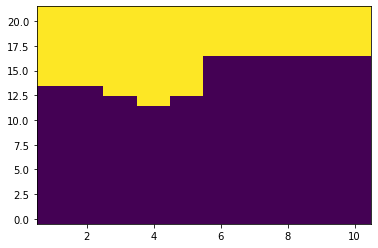

In [190]:
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(0.5, 11.5)
y = np.arange(-0.5, 22.5)
z = np.zeros((22, 10))

for i in range(len(x) - 1):
    for j in range(len(y) - 1):
        action = policy[cards[i], j, False]
        if action['stick'] > action['hit']:
            z[j, i] = 1
        else:
            z[j, i] = 0
            
fig, ax = plt.subplots()
ax.pcolormesh(x, y, z)